In [1]:
import numpy as np
from pysr import PySRRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from data_preprocessing import data_preprocess
import pandas as pd
import matplotlib.pyplot as plt
import sympy as sp
pd.set_option('display.max_colwidth', None)
from sympy import sympify
import seaborn as sns
import os
import warnings
from matplotlib.patches import Patch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
warnings.filterwarnings("ignore")

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


In [2]:
plt.rcParams.update({
    'font.size': 14,           # Global font size for all text
    'font.family': 'DejaVu Sans', # Global font family
    'font.sans-serif': ['DejaVu Sans'],  # Preferred sans-serif font
    'axes.titlesize': 16,      # Font size for titles
    'axes.labelsize': 14,      # Font size for axis labels
    'xtick.labelsize': 12,     # Font size for x-axis tick labels
    'ytick.labelsize': 12,     # Font size for y-axis tick labels
    'legend.fontsize': 12,     # Font size for legends
    'figure.titlesize': 16,    # Font size for figure title
})

In [3]:
def r2_calc(y, y_pred):
    r2 =r2_score(y, y_pred)
    return r2, y, y_pred

def mse_calc(y, y_pred):
    mse = mean_squared_error(y, y_pred)
    return mse

def error_percentage(y, y_pred):
    percentage = np.abs((y - y_pred) / y) * 100
    # delete inf values in percentage
    percentage = percentage[percentage != np.inf]
    error = np.mean(percentage)
    return error

# detect outliers using 3 standard deviation
def detect_outliers(data, threshold=3):
    mean = np.mean(data['delta_phi'])
    std_dev = np.std(data['delta_phi'])
    outliers = []
    for i in data['delta_phi']:
        z_score = (i - mean) / std_dev
        if np.abs(z_score) > threshold:
            outliers.append(i)
    data_without_outliers = data[~data['delta_phi'].isin(outliers)]
    return data_without_outliers

'''def y_calculation(model, origin_data):
    equation = model.sympy()
    # symbols is the column names of the origin data, except the target column:delta_phi
    symbols = sp.symbols(origin_data.columns[:-1])
    equation_func = sp.lambdify(symbols, equation, "numpy")
    y = equation_func(*[origin_data[col] for col in origin_data.columns[:-1]])
    return y, equation'''
    
import sympy as sp
import numpy as np

def y_calculation(model, origin_data):
    equation = model.sympy()
    column_names = origin_data.columns[:-1]
    symbols = sp.symbols(column_names)
    if 'density' in origin_data.columns:
        density = sp.Symbol('density')  # Create a symbol for 'density'
    else:
        raise ValueError("Density column is missing in the input data.")
    density_term = density / (10**(-16) + density**1.005)
    modified_equation = equation * density_term
    equation_func = sp.lambdify(symbols, modified_equation, "numpy")
    inputs = [origin_data[col].values for col in column_names]
    y = equation_func(*inputs)
    return y, modified_equation


def regression_plot(y_origin, y_pred):
    plt.scatter(y_origin, y_pred, color='#955251')
    plt.ylabel('Predicted Value')
    plt.xlabel('True Value')
    r2 = r2_score(y_origin, y_pred)
    MAPE = error_percentage(y_origin, y_pred)
    plt.text(0.1, 0.9, f'$R^2$ = {r2:.3f}', transform=plt.gca().transAxes)
    plt.text(0.1, 0.8, f'MAPE = {MAPE:.3f}%', transform=plt.gca().transAxes)
    plt.ylim(-2,3)
    plt.plot(y_origin, y_origin, color='slategray', linestyle='--')
    
def plot_predict(model, data):
    X = data.drop('delta_phi', axis=1)
    y = model.predict(X)
    #y, equation = y_calculation(model, data)
    plt.figure(figsize=(13, 14))
    plt.subplot(4, 3, 1)
    regression_plot(data['delta_phi'], y)

    plt.subplot(4, 3, 2)
    ymax = max(y.max(), data['delta_phi'].max()) + 0.05
    ymin = min(y.min(), data['delta_phi'].min()) - 0.05
    scatter = plt.scatter(data['density'], data['delta_phi'], c=data['temperature'], cmap='viridis')
    color_bar = plt.colorbar(scatter)
    plt.xlabel('Density')
    plt.ylim(ymin, ymax)
    plt.ylabel('True $\\Delta \\phi$')

    plt.subplot(4, 3, 3)
    scatter = plt.scatter(data['density'], y, c=data['temperature'], cmap='viridis')
    color_bar = plt.colorbar(scatter)
    color_bar.set_label('Temperature')
    plt.xlabel('Density')
    plt.ylim(ymin, ymax)
    plt.ylabel('Predicted $\\Delta \\phi$')

    unique_mw = data['nu'].unique()
    for i in range(1, min(4, len(unique_mw) + 1)):  # Loop through molecular weights
        data_part = data[data['nu'] == unique_mw[i-1]]
        y_part, equation = y_calculation(model, data_part)

        plt.subplot(4, 3, i * 3 + 1)
        regression_plot(data_part['delta_phi'], y_part)

        plt.subplot(4, 3, i * 3 + 2)
        ymax = max(y_part.max(), data_part['delta_phi'].max()) + 0.05
        ymin = min(y_part.min(), data_part['delta_phi'].min()) - 0.05
        scatter = plt.scatter(data_part['density'], data_part['delta_phi'], c=data_part['temperature'], cmap='viridis')
        color_bar = plt.colorbar(scatter)
        plt.xlabel('Density')
        plt.ylim(ymin, ymax)
        plt.ylabel('$\\Delta \\phi$')

        plt.subplot(4, 3, i * 3 + 3)
        scatter = plt.scatter(data_part['density'], y_part, c=data_part['temperature'], cmap='viridis')
        color_bar = plt.colorbar(scatter)
        color_bar.set_label('Temperature')
        plt.xlabel('Density')
        plt.ylim(ymin, ymax)
        plt.ylabel('Predicted $\\Delta \\phi$')
    plt.tight_layout()
    plt.savefig('result_pysr/plot_predict.png', dpi=300, bbox_inches='tight')
    plt.show()

In [85]:
base_path = os.getcwd()
data_n = pd.read_csv(base_path+'/data/processed_data/all_add_features_manual_normalized_n.csv')
data_o = pd.read_csv(base_path+'/data/processed_data/all_add_features_manual_normalized.csv')

In [164]:
data_n.describe()

,density,temperature,nu,Sigma,Epsilon,Kappa_AB,epsilon_AB,delta_phi
count,3.078000e+04,30780.000000,30780.000000,30780.000000,30780.000000,30780.000000,30780.000000,30780.000000
mean,5.197075e-01,2.184506,1.218549,0.919489,0.464695,0.183658,0.183658,-0.418248
std,2.961199e-01,0.666113,0.213151,0.068056,0.256987,0.387212,0.387212,0.440747
min,2.369811e-08,0.690430,1.103434,0.803036,0.308704,0.000000,0.000000,-2.705294
25%,2.583522e-01,1.683281,1.103434,0.910040,0.308704,0.000000,0.000000,-0.534413
50%,5.356165e-01,2.128352,1.139518,0.910040,0.398441,0.000000,0.000000,-0.271616
75%,7.731568e-01,2.683851,1.139518,1.000000,0.398441,0.000000,0.000000,-0.128293
max,1.100528e+00,3.578467,1.666667,1.000000,1.000000,1.000000,1.000000,0.857682


In [10]:
base_path = os.getcwd()
filter_data = pd.read_csv(base_path+'/data/processed_data/all_add_features_filtered.csv')
filter_normalized_data = pd.read_csv(base_path+'/data/processed_data/all_add_features_manual_normalized_n_filtered.csv')
exclude_water = pd.read_csv(base_path+'/data/processed_data/exclude_water_add_features_normalized.csv')
water = pd.read_csv(base_path+'/data/processed_data/water_add_features_filtered_normalized.csv')
print(filter_data.describe().loc[['min', 'max']])
print(filter_normalized_data.describe().loc[['min', 'max']])
print(exclude_water.describe().loc[['min', 'max']])
print(water.describe().loc[['min', 'max']])

       density  temperature  TPSA      MW    LogP  delta_phi
min      0.001        120.0   0.0  16.043 -0.8247  -2.182244
max  56000.000        880.0  31.5  39.948  0.6361   0.974383
          density  temperature        nu     Sigma  delta_phi
min  2.369811e-08     0.690430  1.103434  0.803036  -2.705294
max  1.100528e+00     3.578467  1.666667  1.000000   0.857682
     density  temperature  TPSA      MW  delta_phi
min      1.0          1.0   0.0  16.043  -1.607006
max    100.0        100.0   0.0  39.948  -0.015087
     density  temperature  TPSA      MW    LogP  HallKierAlpha  delta_phi
min      1.0          1.0  31.5  18.015 -0.8247          -0.04   -2.46140
max    100.0        100.0  31.5  18.015 -0.8247          -0.04    7.26987


In [107]:
def metric_extrator(data, title): 
    SUBSTANCES = os.listdir(f'{base_path}/result_pysr')
    SUBSTANCES = [substance.split('.')[0] for substance in SUBSTANCES if substance.endswith('.pkl')]
    if title == 'manual_normalized':
        SUBSTANCES = [substance for substance in SUBSTANCES if 'manual_normalized_iter' in substance
                      and 'pySR_w_' not in substance]
    elif title == 'manual_normalized_n':
        SUBSTANCES = [substance for substance in SUBSTANCES if 'manual_normalized_n_iter' in substance]
    elif title == 'manual_filter_normalized':
        SUBSTANCES = [substance for substance in SUBSTANCES if 'manual_normalized_n_filtered_iter' in substance
                      and 'pySR_w_all' not in substance]
    elif title == 'manual_normalized_weighted':
        SUBSTANCES = [substance for substance in SUBSTANCES if 'pySR_w_all' in substance]
    elif title == 'water':
        SUBSTANCES = [substance for substance in SUBSTANCES if substance.startswith('pySR_water')]
    else:
        raise ValueError("The title is not correct.")
    # columns is unique mw
    R2_s = pd.DataFrame(index=range(len(SUBSTANCES)), columns=data['nu'].unique())
    MSE = pd.DataFrame(index=range(len(SUBSTANCES)), columns=data['nu'].unique())
    MAPE = pd.DataFrame(index=range(len(SUBSTANCES)), columns=data['nu'].unique())
    R2=[]
    COMPLEXITY = []
    equations = []
    Y_PRED = []
    print(f"total {len(SUBSTANCES)} files \n", SUBSTANCES)
    for iter, substance in enumerate(SUBSTANCES):
        data_p = data
        model = PySRRegressor.from_file(f'{base_path}/result_pysr/{substance}.pkl')
        unique_mw = data_p['nu'].unique()
        unique_mw.sort()
        for j, mw in enumerate(unique_mw):
            data_mw = data_p[data_p['nu'] == mw]
            X = data_mw.drop(columns=['delta_phi'])
            y = data_mw['delta_phi']
            y_pred = model.predict(X)
            r2 = r2_calc(y, y_pred)
            mse = mse_calc(y, y_pred)
            mape = error_percentage(y, y_pred)
            R2_s.iloc[iter,j] = r2[0]
            MSE.iloc[iter,j] = mse*0.01
            MAPE.iloc[iter,j] = mape*0.01
        _ , equation = y_calculation(model, data_p)
        complexity = model.get_best()['complexity']
        equations.append(equation)
        COMPLEXITY.append(complexity)
        X_t = data_p.drop(columns=['delta_phi'])
        y_pred_t = model.predict(X_t)
        R2.append(r2_calc(data_p['delta_phi'], y_pred_t)[0])
        Y_PRED.append(pd.DataFrame(y_pred_t))
        #Y_PRED = pd.concat([Y_PRED, pd.DataFrame(y_pred_)], axis=1)
    equations = pd.DataFrame(equations)
    equations.columns = ['equations']
    equations.to_excel(f'{base_path}/result_pysr/equations_{title}.xlsx', index=False)
    # rename the columns of R2_s, MSE, MAPE
    # The largest column name is argon, the smallest column name is methane, the other one is water
    if len(data['nu'].unique()) == 3:
        R2_s.columns = ['argon', 'methane', 'water']
        MSE.columns = ['argon', 'methane', 'water']
        MAPE.columns = ['argon', 'methane', 'water']
    elif len(data['nu'].unique()) == 2:
        # methane and argon
        R2_s.columns = ['argon', 'methane', 'water']
        MSE.columns = ['argon', 'methane', 'water']
        MAPE.columns = ['argon', 'methane', 'water']
    else:
        # water
        R2_s.columns = ['water']
        MSE.columns = ['water']
        MAPE.columns = ['water']
    return R2, MSE, MAPE, COMPLEXITY, Y_PRED, R2_s
    


In [186]:
R2_m, MSE_m, MAPE_m, COMPLEXITY_m, Y_PRED_m,R2_sm = metric_extrator(data_o, 'manual_normalized')
R2_mn, MSE_mn, MAPE_mn, COMPLEXITY_mn, Y_PRED_mn, R2_smn = metric_extrator(data_n, 'manual_normalized_n')
R2_mfn, MSE_mfn, MAPE_mfn, COMPLEXITY_mfn, Y_PRED_mfn, R2_smfn = metric_extrator(filter_normalized_data, 'manual_filter_normalized')
R2_mnw, MSE_mnw, MAPE_mnw, COMPLEXITY_mnw, Y_PRED_mnw, R2_smnw = metric_extrator(data_n, 'manual_normalized_weighted')


total 5 files 
 ['pySR_all_add_features_manual_normalized_iter500_1451', 'pySR_all_add_features_manual_normalized_iter500_1621', 'pySR_all_add_features_manual_normalized_iter500_1602', 'pySR_all_add_features_manual_normalized_iter500_1516', 'pySR_all_add_features_manual_normalized_iter500_1543']
Checking if /home/ruilwang/ML-uv-theory/result_pysr/pySR_all_add_features_manual_normalized_iter500_1451.pkl exists...
Loading model from /home/ruilwang/ML-uv-theory/result_pysr/pySR_all_add_features_manual_normalized_iter500_1451.pkl
Checking if /home/ruilwang/ML-uv-theory/result_pysr/pySR_all_add_features_manual_normalized_iter500_1621.pkl exists...
Loading model from /home/ruilwang/ML-uv-theory/result_pysr/pySR_all_add_features_manual_normalized_iter500_1621.pkl
Checking if /home/ruilwang/ML-uv-theory/result_pysr/pySR_all_add_features_manual_normalized_iter500_1602.pkl exists...
Loading model from /home/ruilwang/ML-uv-theory/result_pysr/pySR_all_add_features_manual_normalized_iter500_1602.pk

In [187]:
titles = ['before, normalized', 
          'normalized',
            'normalized, selected',
            'normalized, weighted']
R2SS = [R2_sm, R2_smn, R2_smfn, R2_smnw]
MSESS = [MSE_m, MSE_mn, MSE_mfn, MSE_mnw]
MAPESS = [MAPE_m, MAPE_mn, MAPE_mfn, MAPE_mnw]
for i in range(len(titles)):
    R2SS[i]['Dataset'] = titles[i]
    MSESS[i]['Dataset'] = titles[i]
    MAPESS[i]['Dataset'] = titles[i]
R2_s = pd.concat(R2SS, axis=0)
MSE_s = pd.concat(MSESS, axis=0)
MAPE_s = pd.concat(MAPESS, axis=0)
R2_s = R2_s.melt(id_vars='Dataset', var_name='Substance', value_name='Value')
MSE_s = MSE_s.melt(id_vars='Dataset', var_name='Substance', value_name='Value')
MAPE_s = MAPE_s.melt(id_vars='Dataset', var_name='Substance', value_name='Value')

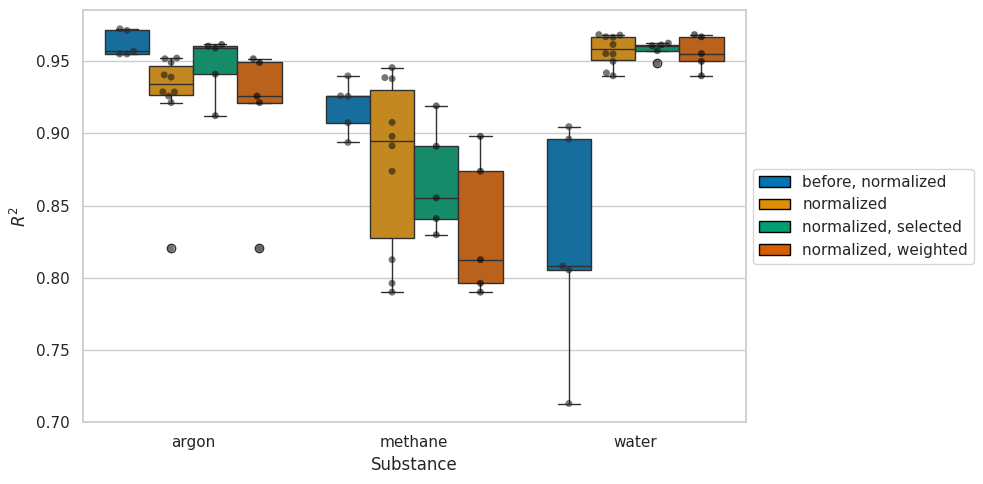

In [188]:
colors = sns.color_palette("colorblind", 4)
# Define hatches for each substance
df = R2_s
# Create the boxplot with Seaborn
plt.figure(figsize=(10, 5))
ax = sns.boxplot(data=df, x="Substance", y="Value", hue="Dataset", palette=colors)
ax = sns.swarmplot(data=df, x="Substance", y="Value", hue="Dataset", 
                   color='black', alpha=0.6, dodge=True)
color_legend = [Patch(facecolor=color, edgecolor='black', label=label)
                for label, color in zip(titles, colors)]
# put the legend outside the plot, on the right side of the plot
plt.legend(handles=color_legend, loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("Substance")
plt.ylabel(f"$R^2$")
plt.tight_layout()
plt.savefig(f'{base_path}/result_pysr/MSE_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

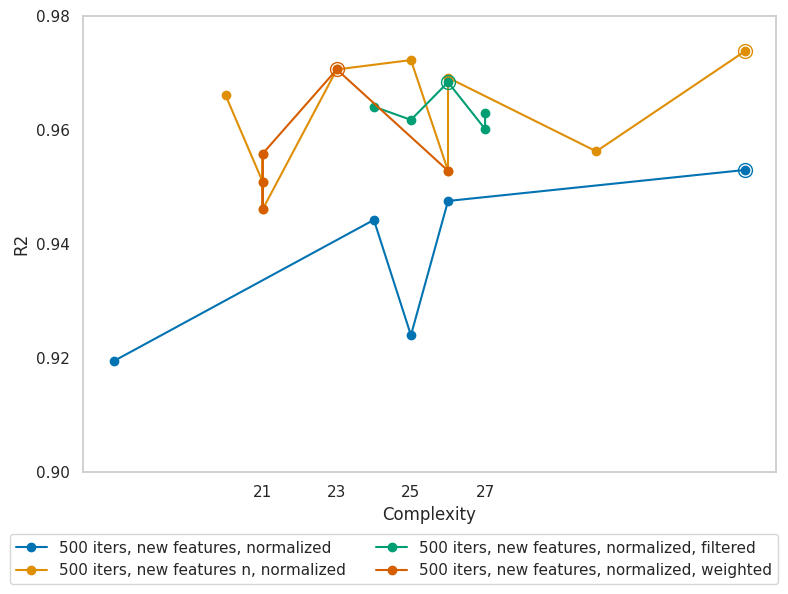

In [190]:
R2S = [R2_m, R2_mn, R2_mfn, R2_mnw]
COMPLEXITIES = [COMPLEXITY_m, COMPLEXITY_mn, COMPLEXITY_mfn, COMPLEXITY_mnw]
Y_PREDs = [Y_PRED_m, Y_PRED_mn, Y_PRED_mfn, Y_PRED_mnw]
titles = ['new features, normalized',
          'new features n, normalized',
            'new features, normalized, filtered',
            'new features, normalized, weighted']

COLORS = sns.color_palette("colorblind", 4)

fig = plt.figure(figsize=(8, 6))
ax2 = fig.add_subplot(1, 1, 1)
for i in range(len(R2S)):
    data = {'R2': R2S[i], 'Complexity': COMPLEXITIES[i]}
    df = pd.DataFrame(data).sort_values(by='Complexity').reset_index(drop=True)
    ax2.plot(df['Complexity'], df['R2'], 'o-', color=COLORS[i], label=f'500 iters, {titles[i]}')
    max_r2 = df['R2'].max()
    max_complexity = df['Complexity'][df['R2'].idxmax()]
    ax2.plot(max_complexity, max_r2, 'o', color=COLORS[i], markersize=10, markerfacecolor='none')
ax2.set_xlabel('Complexity')
ax2.set_ylabel('R2')
ax2.set_xticks(np.arange(min(min(COMPLEXITIES)), max(max(COMPLEXITIES)) + 2, 2))
ax2.set_yticks(np.arange(round(min(min(R2S)) - 0.02, 2), round(max(max(R2S)) + 0.02, 2), 0.02))
ax2.grid()

handles, labels = ax2.get_legend_handles_labels()  # Get handles and labels from the pareto plot
fig.legend(handles, labels, loc='lower center', bbox_to_anchor=(0.5,0), ncol=2, shadow=False)

# Adjust layout to fit legends and color bars
plt.tight_layout()
plt.subplots_adjust(bottom=0.2)  # Adjust bottom to make space for the legend
plt.show()

Checking if /home/ruilwang/ML-uv-theory/result_pysr/pySR_w_all_add_features_manual_normalized_n_iter500_2330.pkl exists...
Loading model from /home/ruilwang/ML-uv-theory/result_pysr/pySR_w_all_add_features_manual_normalized_n_iter500_2330.pkl


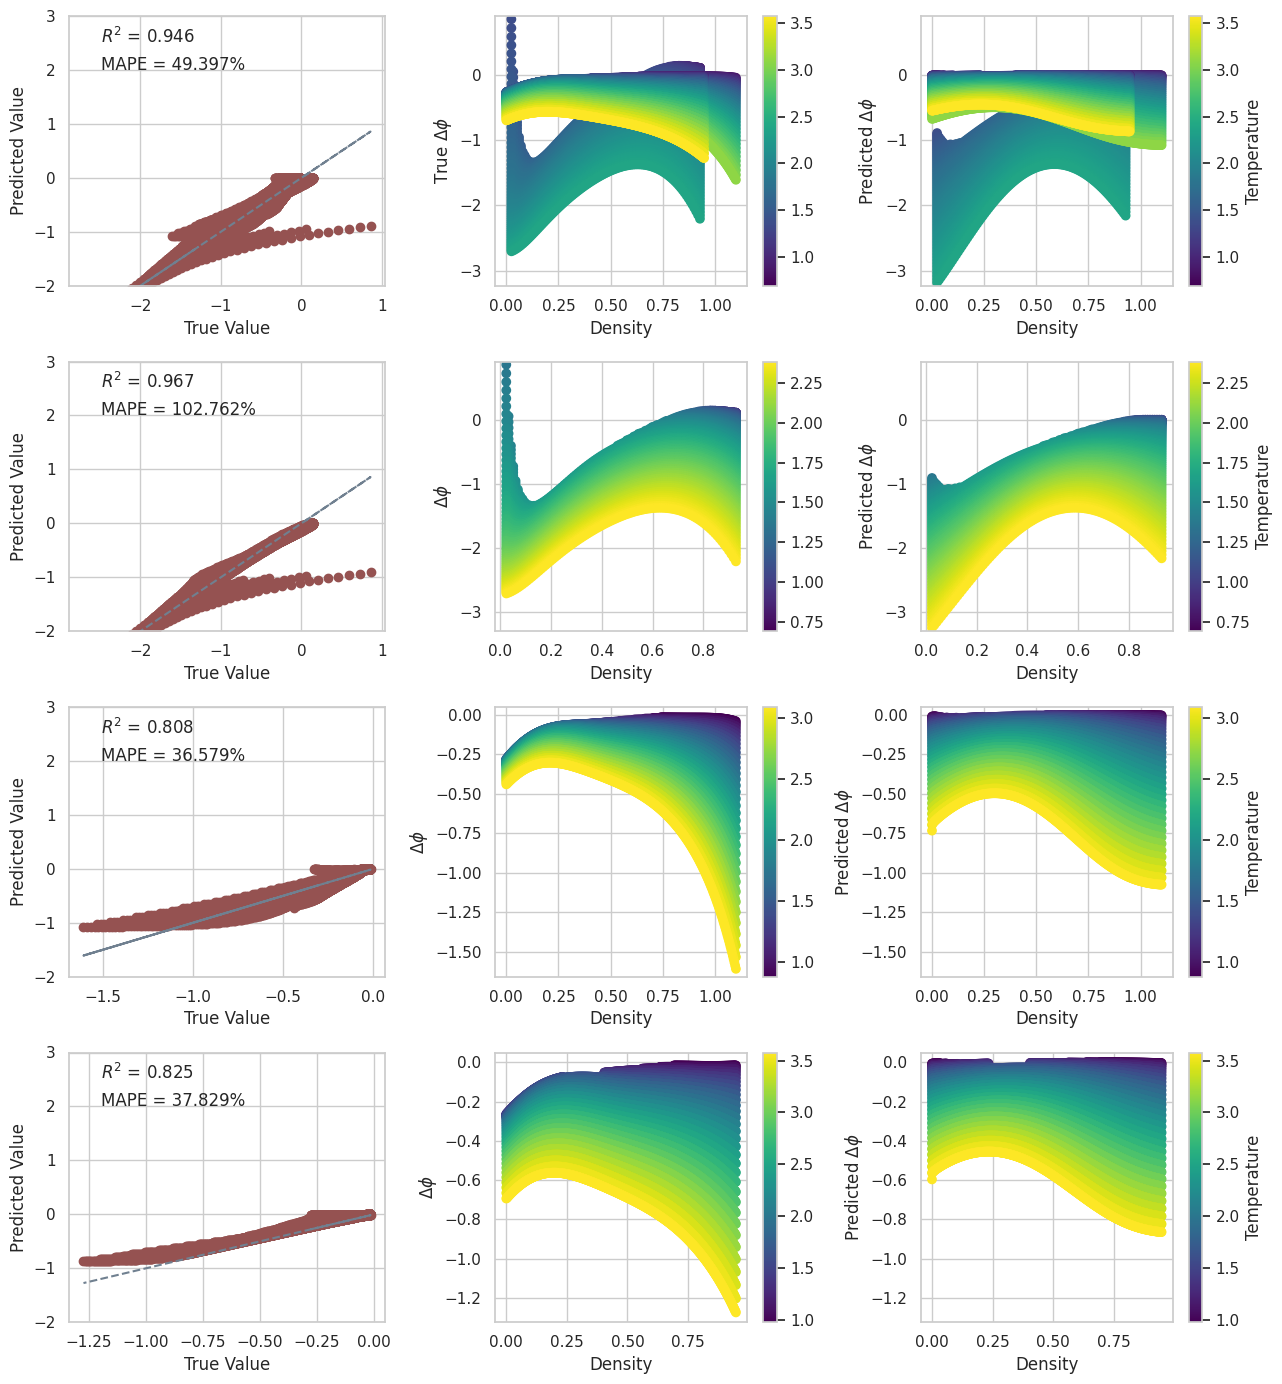

In [115]:
file_name = 'pySR_w_all_add_features_manual_normalized_n_iter500_2330'
data_p = data_n
model = PySRRegressor.from_file(f'{base_path}/result_pysr/{file_name}.pkl')
plot_predict(model, data_p)

In [83]:
equation = model.sympy()
# simplify the equation
equation = sp.simplify(equation)
variables = list(equation.free_symbols)  # Get symbols from the equation
print("Variables:", variables)

Variables: [nu, density, temperature]


In [ ]:
SUBSTANCES = os.listdir(f'{base_path}/result_pysr')
SUBSTANCES = [substance.split('.')[0] for substance in SUBSTANCES if substance.endswith('.pkl')]
SUBSTANCES = [substance for substance in SUBSTANCES if 'manual_normalized_n_iter' in substance]
print(f"Total {len(SUBSTANCES)} files \n", SUBSTANCES)

# DataFrame to store feature importances
importance_table = pd.DataFrame()

for iter, substance in enumerate(SUBSTANCES):
    print(f"Processing model: {substance}")
    # Load model
    model = PySRRegressor.from_file(f'{base_path}/result_pysr/{substance}.pkl')
    equation = model.sympy()
    
    # Simplify the equation
    equation = sp.simplify(equation)
    variables = list(equation.free_symbols)  # Get symbols from the equation
    print("Variables:", variables)
    
    # Define variable ranges from data
    ranges = {var: (min(data_n[str(var)]), max(data_n[str(var)])) for var in variables}
    num_samples = 5
    
    # Generate sample points
    sample_points = {
        var: np.linspace(ranges[var][0], ranges[var][1], num_samples)
        for var in ranges
    }
    
    # Create a meshgrid of all variable combinations
    mesh = np.meshgrid(*sample_points.values(), indexing='ij')
    sample_combinations = {var: grid.ravel() for var, grid in zip(ranges.keys(), mesh)}
    
    # Calculate average importance for each variable
    variable_importance = {}
    for var in variables:
        partial_derivative = sp.diff(equation, var)  # Compute partial derivative
        slopes = []
        for i in range(len(mesh[0].ravel())):
            # Create a dictionary of variable values at this point
            values = {v: sample_combinations[v][i] for v in ranges.keys()}
            # Evaluate the derivative and store its absolute value
            slope_value = abs(partial_derivative.evalf(subs=values))
            slopes.append(slope_value)
        # Average the slopes
        variable_importance[str(var)] = np.mean(slopes)
    
    # Normalize importance for comparison
    total_importance = sum(variable_importance.values())
    normalized_importance = {key: val / total_importance for key, val in variable_importance.items()}
    
    # Store in DataFrame
    importance_table = pd.concat([importance_table, pd.DataFrame(normalized_importance, index=[substance])]
    )


Total 10 files 
 ['pySR_w_all_add_features_manual_normalized_n_iter500_0029', 'pySR_w_all_add_features_manual_normalized_n_iter500_2330', 'pySR_w_all_add_features_manual_normalized_n_iter500_0016', 'pySR_all_add_features_manual_normalized_n_iter500_1655', 'pySR_all_add_features_manual_normalized_n_iter500_1821', 'pySR_w_all_add_features_manual_normalized_n_iter500_0056', 'pySR_all_add_features_manual_normalized_n_iter500_1718', 'pySR_all_add_features_manual_normalized_n_iter500_1741', 'pySR_all_add_features_manual_normalized_n_iter500_1805', 'pySR_w_all_add_features_manual_normalized_n_iter500_0003']
Processing model: pySR_w_all_add_features_manual_normalized_n_iter500_0029
Checking if /home/ruilwang/ML-uv-theory/result_pysr/pySR_w_all_add_features_manual_normalized_n_iter500_0029.pkl exists...
Loading model from /home/ruilwang/ML-uv-theory/result_pysr/pySR_w_all_add_features_manual_normalized_n_iter500_0029.pkl
Variables: [Sigma, density, epsilon_AB, temperature]
Processing model: pyS

TypeError: Could not convert [1.73041682113155] to numeric

In [153]:
importance_long = importance_table.reset_index().melt(
    id_vars='index',  # Preserve model names if needed
    var_name='Feature',  # Column name for features
    value_name='Importance'  # Column name for importance values
)
importance_long['Importance'] = importance_long['Importance'].astype(float)

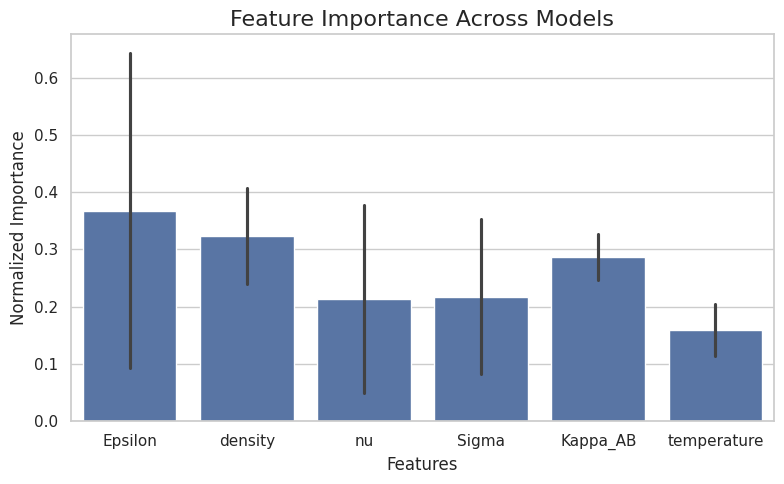

In [192]:
plt.figure(figsize=(8, 5))
#sns.boxplot(data=importance_long, x='Feature', y='Importance')
# plot barplot with error bars, from highest to lowest mean importance
importance_long = importance_long.sort_values('Importance', ascending=False)
sns.barplot(data=importance_long, x='Feature', y='Importance', ci='sd')
plt.title('Feature Importance Across Models', fontsize=16)
plt.xticks(rotation=0)
plt.ylabel('Normalized Importance')
plt.xlabel('Features')
plt.tight_layout()
plt.show()


In [ ]:
importance_table.iloc[0,3]

AttributeError: 'Float' object has no attribute 'dtype'

In [65]:
variable_importance

{'Sigma': 0.395562759557948,
 'density': 2.16872940168509,
 'temperature': 1.06945836583256,
 'nu': 0.773147023085083,
 'Kappa_AB': 1.69715995106867}

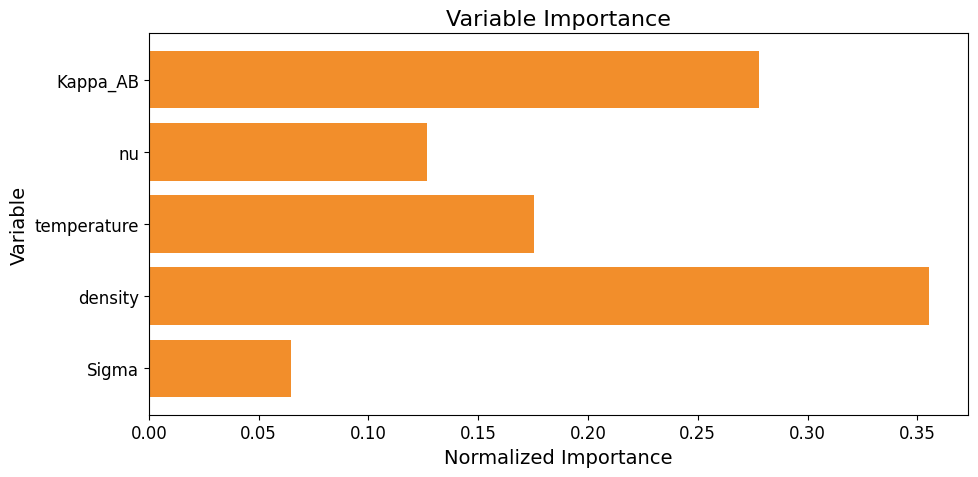

In [26]:
plt.figure(figsize=(10, 5))
plt.barh(list(normalized_importance.keys()), normalized_importance.values(), color='#F28E2B')
plt.xlabel("Normalized Importance")
plt.ylabel("Variable")
plt.title("Variable Importance")
plt.tight_layout()
plt.show()

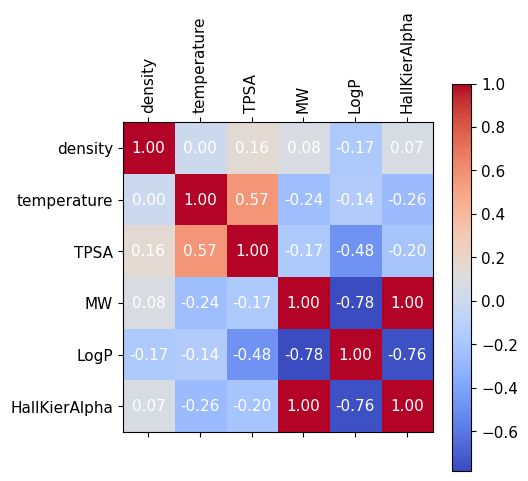

In [33]:
# calculate the person correlation coefficient of X
# plot the heatmap of the correlation matrix, show the correlation coefficient value in the heatmap
# fontsize
plt.rc('font', size=11)
corr = X.corr()
plt.figure(figsize=(5, 5))
plt.matshow(corr, fignum=1, cmap='coolwarm')
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation='vertical')
plt.yticks(range(len(corr.columns)), corr.columns)
for (i, j), val in np.ndenumerate(corr):
    plt.text(j, i, f'{val:.2f}', ha='center', va='center', color='white')
plt.show()

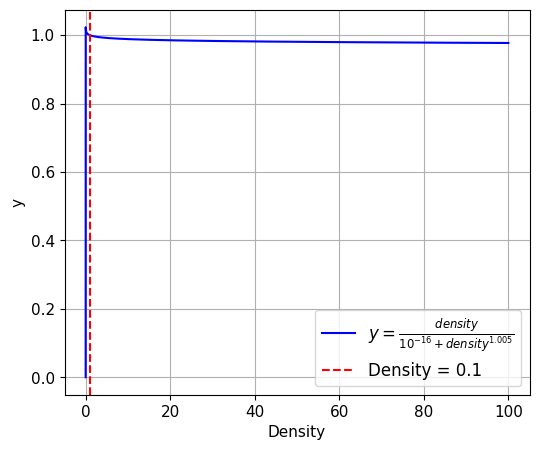

In [34]:
import numpy as np
import matplotlib.pyplot as plt

# Define the density range
density = np.linspace(0, 100, 10000)  # Generate values from 0 to 10

# Define the custom weight function
weights = density / (10**(-16) + density**1.005)

# Plot the function
plt.figure(figsize=(6, 5))
plt.plot(density, weights, label=r'$y = \frac{density}{10^{-16} + density^{1.005}}$', color='blue')
plt.xlabel('Density')
plt.ylabel('y')
# plot x = 0.1
plt.axvline(x=1, color='red', linestyle='--', label='Density = 0.1')
plt.grid(True)
plt.legend(fontsize=12)
plt.show()



In [97]:
# print the equation and its complexity
best_model = model.get_best()
print(best_model)

complexity                                                                                               16
loss                                                                                               0.014068
score                                                                                               0.12741
equation         cube(-0.0067469096 * (0.2287218 * ((sqrt(density) * sin(-0.9328978 + MW)) + temperature)))
sympy_format                      3.67483085472592e-9*(-sqrt(density)*sin(MW - 0.9328978) - temperature)**3
lambda_format    PySRFunction(X=>3.67483085472592e-9*(-sqrt(density)*sin(MW - 0.9328978) - temperature)**3)
Name: 12, dtype: object


In [96]:
from sympy import symbols, limit, oo
density,temperature  = sp.symbols('density temperature')
new_eqaution = density*model.sympy()
res1=(new_eqaution).subs(density, 0)==0
restriction_2 = limit(equation, temperature, +oo).is_finite
print(res1,restriction_2)


True False


In [95]:
from sympy import diff
equation = model.sympy()
symbols_in_equation = equation.free_symbols
print("Symbols in the equation:", symbols_in_equation)
partials = {str(sym): diff(equation, sym) for sym in symbols_in_equation}
print("\nPartial derivatives:")
for sym, derivative in partials.items():
    print(f"∂/∂{sym}:", derivative)

Symbols in the equation: {temperature, density, MW}

Partial derivatives:
∂/∂temperature: -1.10244925641778e-8*(-sqrt(density)*sin(MW - 0.9328978) - temperature)**2
∂/∂density: -5.51224628208888e-9*(-sqrt(density)*sin(MW - 0.9328978) - temperature)**2*sin(MW - 0.9328978)/sqrt(density)
∂/∂MW: -1.10244925641778e-8*sqrt(density)*(-sqrt(density)*sin(MW - 0.9328978) - temperature)**2*cos(MW - 0.9328978)


In [160]:
import pandas as pd
data_a = pd.read_csv('data/processed_data/all_add_features_filtered_normalized.csv')
data= pd.read_csv('data/processed_data/exclude_water.csv')
data_n = pd.read_csv('data/processed_data/exclude_add_features_normalized.csv')
data_n1 = pd.read_csv('data/processed_data/exclude_water_add_features_normalized.csv')
data_fn = pd.read_csv('data/processed_data/exclude_add_features_filtered_normalized.csv')
data_water = pd.read_csv('data/processed_data/water_add_features_normalized.csv')

In [ ]:
data_n.describe().loc[['min', 'max']]


,density,temperature,TPSA,MW,delta_phi
min,1.0,1.0,0.0,16.043,-1.607006
max,100.0,100.0,0.0,39.948,-0.015087


In [159]:
data_n1.describe().loc[['min', 'max']]

,density,temperature,TPSA,MW,delta_phi
min,1.0,1.0,0.0,16.043,-1.607006
max,100.0,100.0,0.0,39.948,-0.015087


In [4]:
from sympy import symbols, limit, oo
x = symbols('x')
limit_value = limit('sin(x)', x, oo).is_finite
print(limit_value)

True


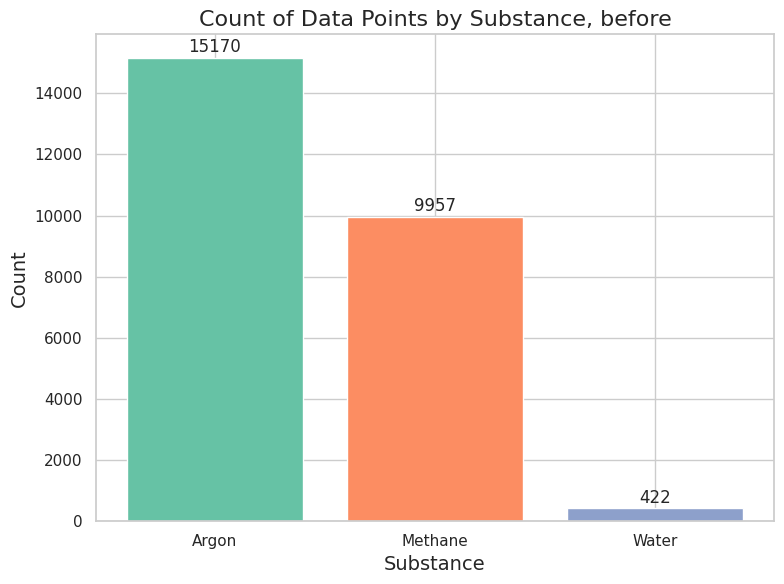

In [103]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Assuming `data_n['nu']` contains the data to count
unique, counts = np.unique(data_o['nu'], return_counts=True)

# Define the substances (must match the unique values in `data_n['nu']`)
substances = ['Argon', 'Methane', 'Water']  # Capitalized for readability

# Ensure counts align correctly (sorting if necessary)
if len(counts) != len(substances):
    raise ValueError("Mismatch between substances and counts. Check data alignment.")

# Plotting
sns.set(style="whitegrid")  # Apply seaborn styling
plt.figure(figsize=(8, 6))

# Bar chart with defined color palette
colors = sns.color_palette("Set2")[:len(substances)]
plt.bar(substances, counts, color=colors)

# Add axis labels and a title
plt.xlabel('Substance', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Count of Data Points by Substance, before', fontsize=16)
# Add value annotations
for i, count in enumerate(counts):
    plt.text(i, count + 50, str(count), ha='center', va='bottom', fontsize=12)

# Display plot
plt.tight_layout()
plt.show()
